# **Time Series Analysis w/ ARIMA**

In the previous project, we explored time series analysis and forecasting using moving averages and an LSTM neural network model. We had ignored stationarity in the previous project. In this project, ***we dive into stationarity as it is critical for any time-series analysis.*** 

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Plotting Format
font = {'family':'normal', 'weight':'bold','size':16}
matplotlib.rc('font', **font)
color = 'black'
matplotlib.rcParams['text.color'] = color
matplotlib.rcParams['axes.labelcolor'] = color
matplotlib.rcParams['xtick.color'] = color
matplotlib.rcParams['ytick.color'] = color

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive/My Drive/Stock Data/SPY.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Import and Format Data**

In [4]:
data = pd.read_csv(path)
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500
5,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.916538,492100
6,1993-02-08,44.96875,45.12500,44.90625,44.96875,26.916538,596100
7,1993-02-09,44.81250,44.81250,44.56250,44.65625,26.729490,122100
8,1993-02-10,44.65625,44.75000,44.53125,44.71875,26.766899,379600
9,1993-02-11,44.78125,45.12500,44.78125,44.93750,26.897835,19500


In [5]:
dateparser = lambda dt: pd.datetime.strptime(dt, '%Y-%m-%d')
data = pd.read_csv(path, parse_dates = ['Date'], index_col = 'Date', date_parser = dateparser)
data.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500
1993-02-05,44.96875,45.06250,44.71875,44.96875,26.916538,492100
1993-02-08,44.96875,45.12500,44.90625,44.96875,26.916538,596100
1993-02-09,44.81250,44.81250,44.56250,44.65625,26.729490,122100
1993-02-10,44.65625,44.75000,44.53125,44.71875,26.766899,379600


In [0]:
data = data['Close']

In [0]:
def plot_series(data, title):
  fig = plt.figure(figsize=(40,10), facecolor = 'honeydew')
  ax = fig.add_subplot(1,1,1)
  ax.plot(data, color = 'blue')
  ax.set_title(title)
  fig.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


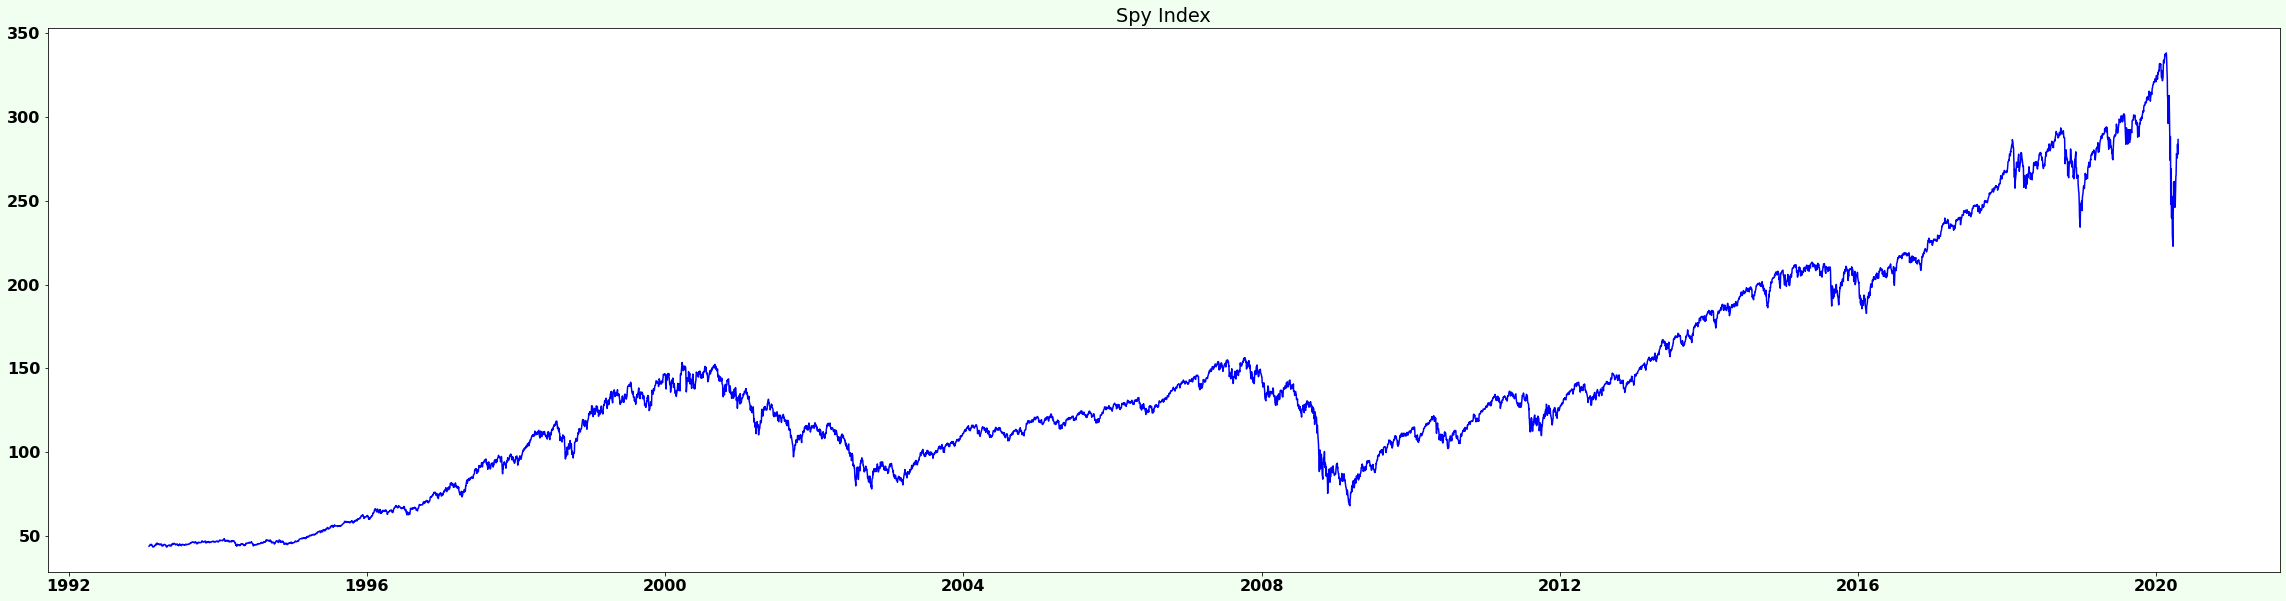

In [8]:
plot_series(data, 'Spy Index')

# **Checking for Stationarity**
A Time Series is said to be stationary if its statistical properties such as mean and variance remain constant over time. Time-Series models assume that the time series is stationary, which is why its important to check if a time series is stationary. 

A Time Series is said to be statioary if it satisfies the following conditions:
>* Constant Mean
>* Constant Variance
>* An autocovariance that does not depend on time

We can check a time-series for stationarity using the following:
>1. Rolling Statistics
>2. Dickey-Fuller Test

In [0]:
def stationary_test(data):
  ''' First Determine the Rolling Statistics '''
  roll_mean = data.rolling(252).mean()
  roll_std = data.rolling(252).std()
  ''' Plotting the Rolling Statistics '''
  fig = plt.figure(figsize = (40,10), facecolor = 'honeydew')
  ax = fig.add_subplot(1,1,1)
  ax.plot(data, color = 'blue', label = 'Original')
  ax.plot(roll_mean, color = 'red', label = '252-Rolling Mean')
  ax.plot(roll_std, color = 'black', label = '252-Rolling Standard Deviation')
  ax.legend(loc = 'best')
  fig.suptitle('Stationarity Test')
  fig.show()
  ''' Dickey-Fuller Test'''
  test = adfuller(data, autolag = 'AIC')
  output = pd.Series(test[0:4], index = ['Test Statistic', 'p-Value', 'Lags Used', 'Observations Used'])
  for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
  print('\tDickey Fuller Test\n\nH_O = Series is Not Stationary\nH_A = Series is Stationary\n\n')
  print(output)

	Dickey Fuller Test

H_O = Series is Not Stationary
H_A = Series is Stationary


Test Statistic            -0.085576
p-Value                    0.950856
Lags Used                 26.000000
Observations Used       6827.000000
Critical Value (1%)       -3.431308
Critical Value (5%)       -2.861963
Critical Value (10%)      -2.566995
dtype: float64


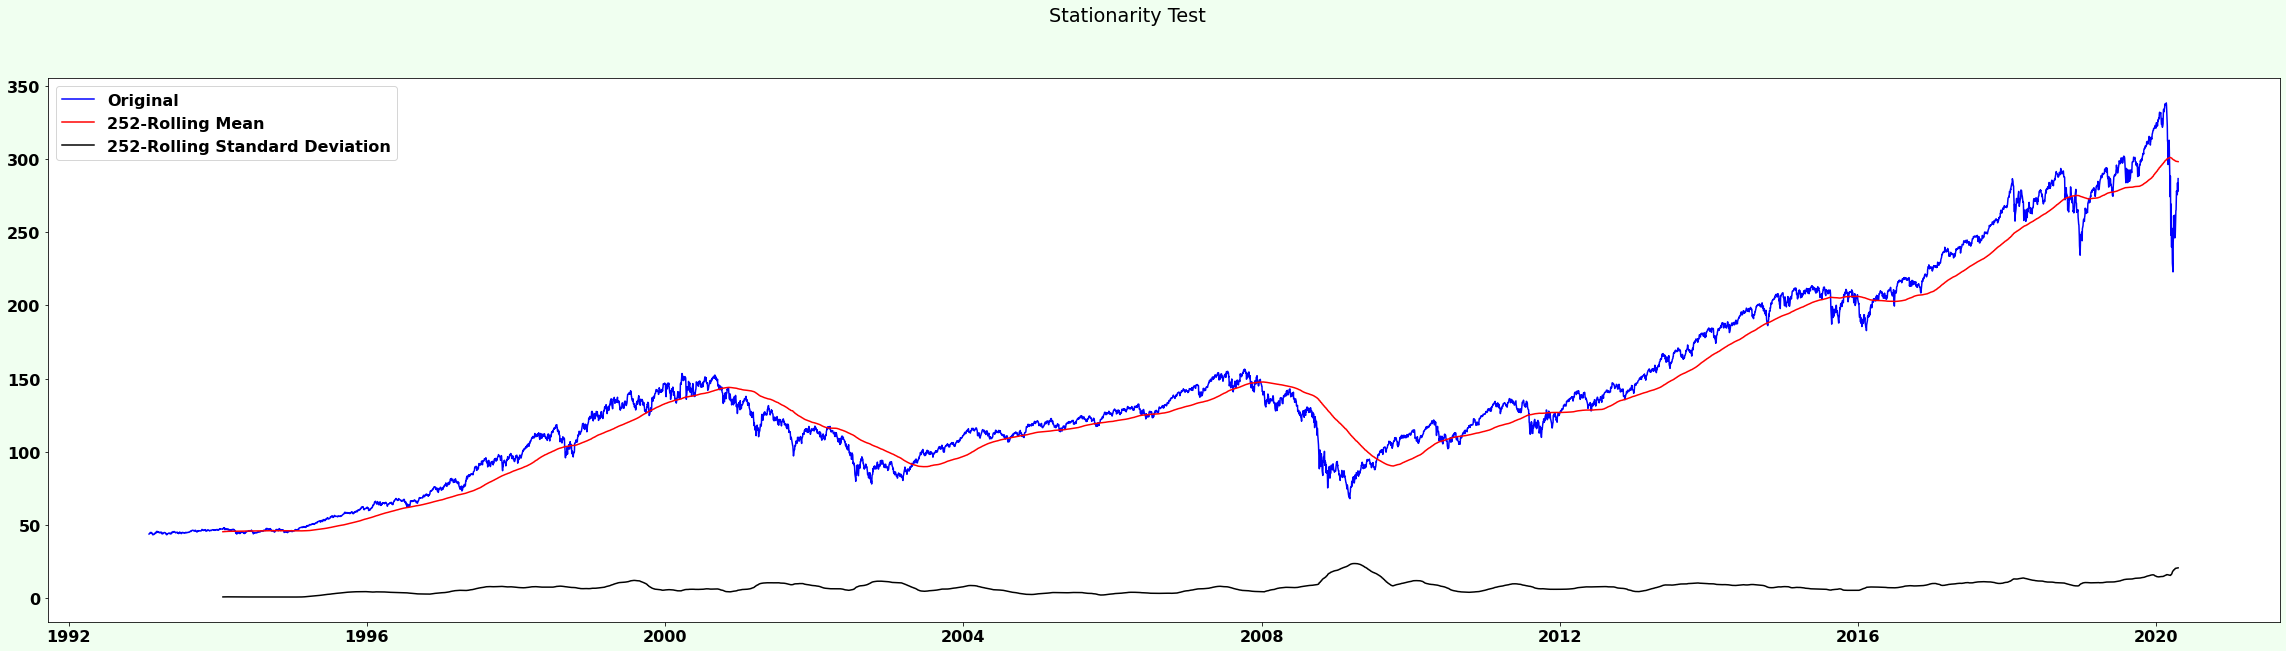

In [10]:
stationary_test(data)

## **Some Observations**

From the rolling statisics, we see that the moving average is not constant--indicating to us that the time series is not stationary. The test statistic is also greater than the criticial values--which leads us to accept the null hypothesis that the time series is not stationary.

# **Modeling and Eliminating Trend and Seasonality**

A non-stationary time series is made up of seasonality, trend, and residuals. By decomposing the time series into its components, we can attempt to stationarize it.

In [0]:
decomposition = seasonal_decompose(data, freq = 63)
decomp_trend = decomposition.trend
decomp_season = decomposition.seasonal
decomp_resid = decomposition.resid

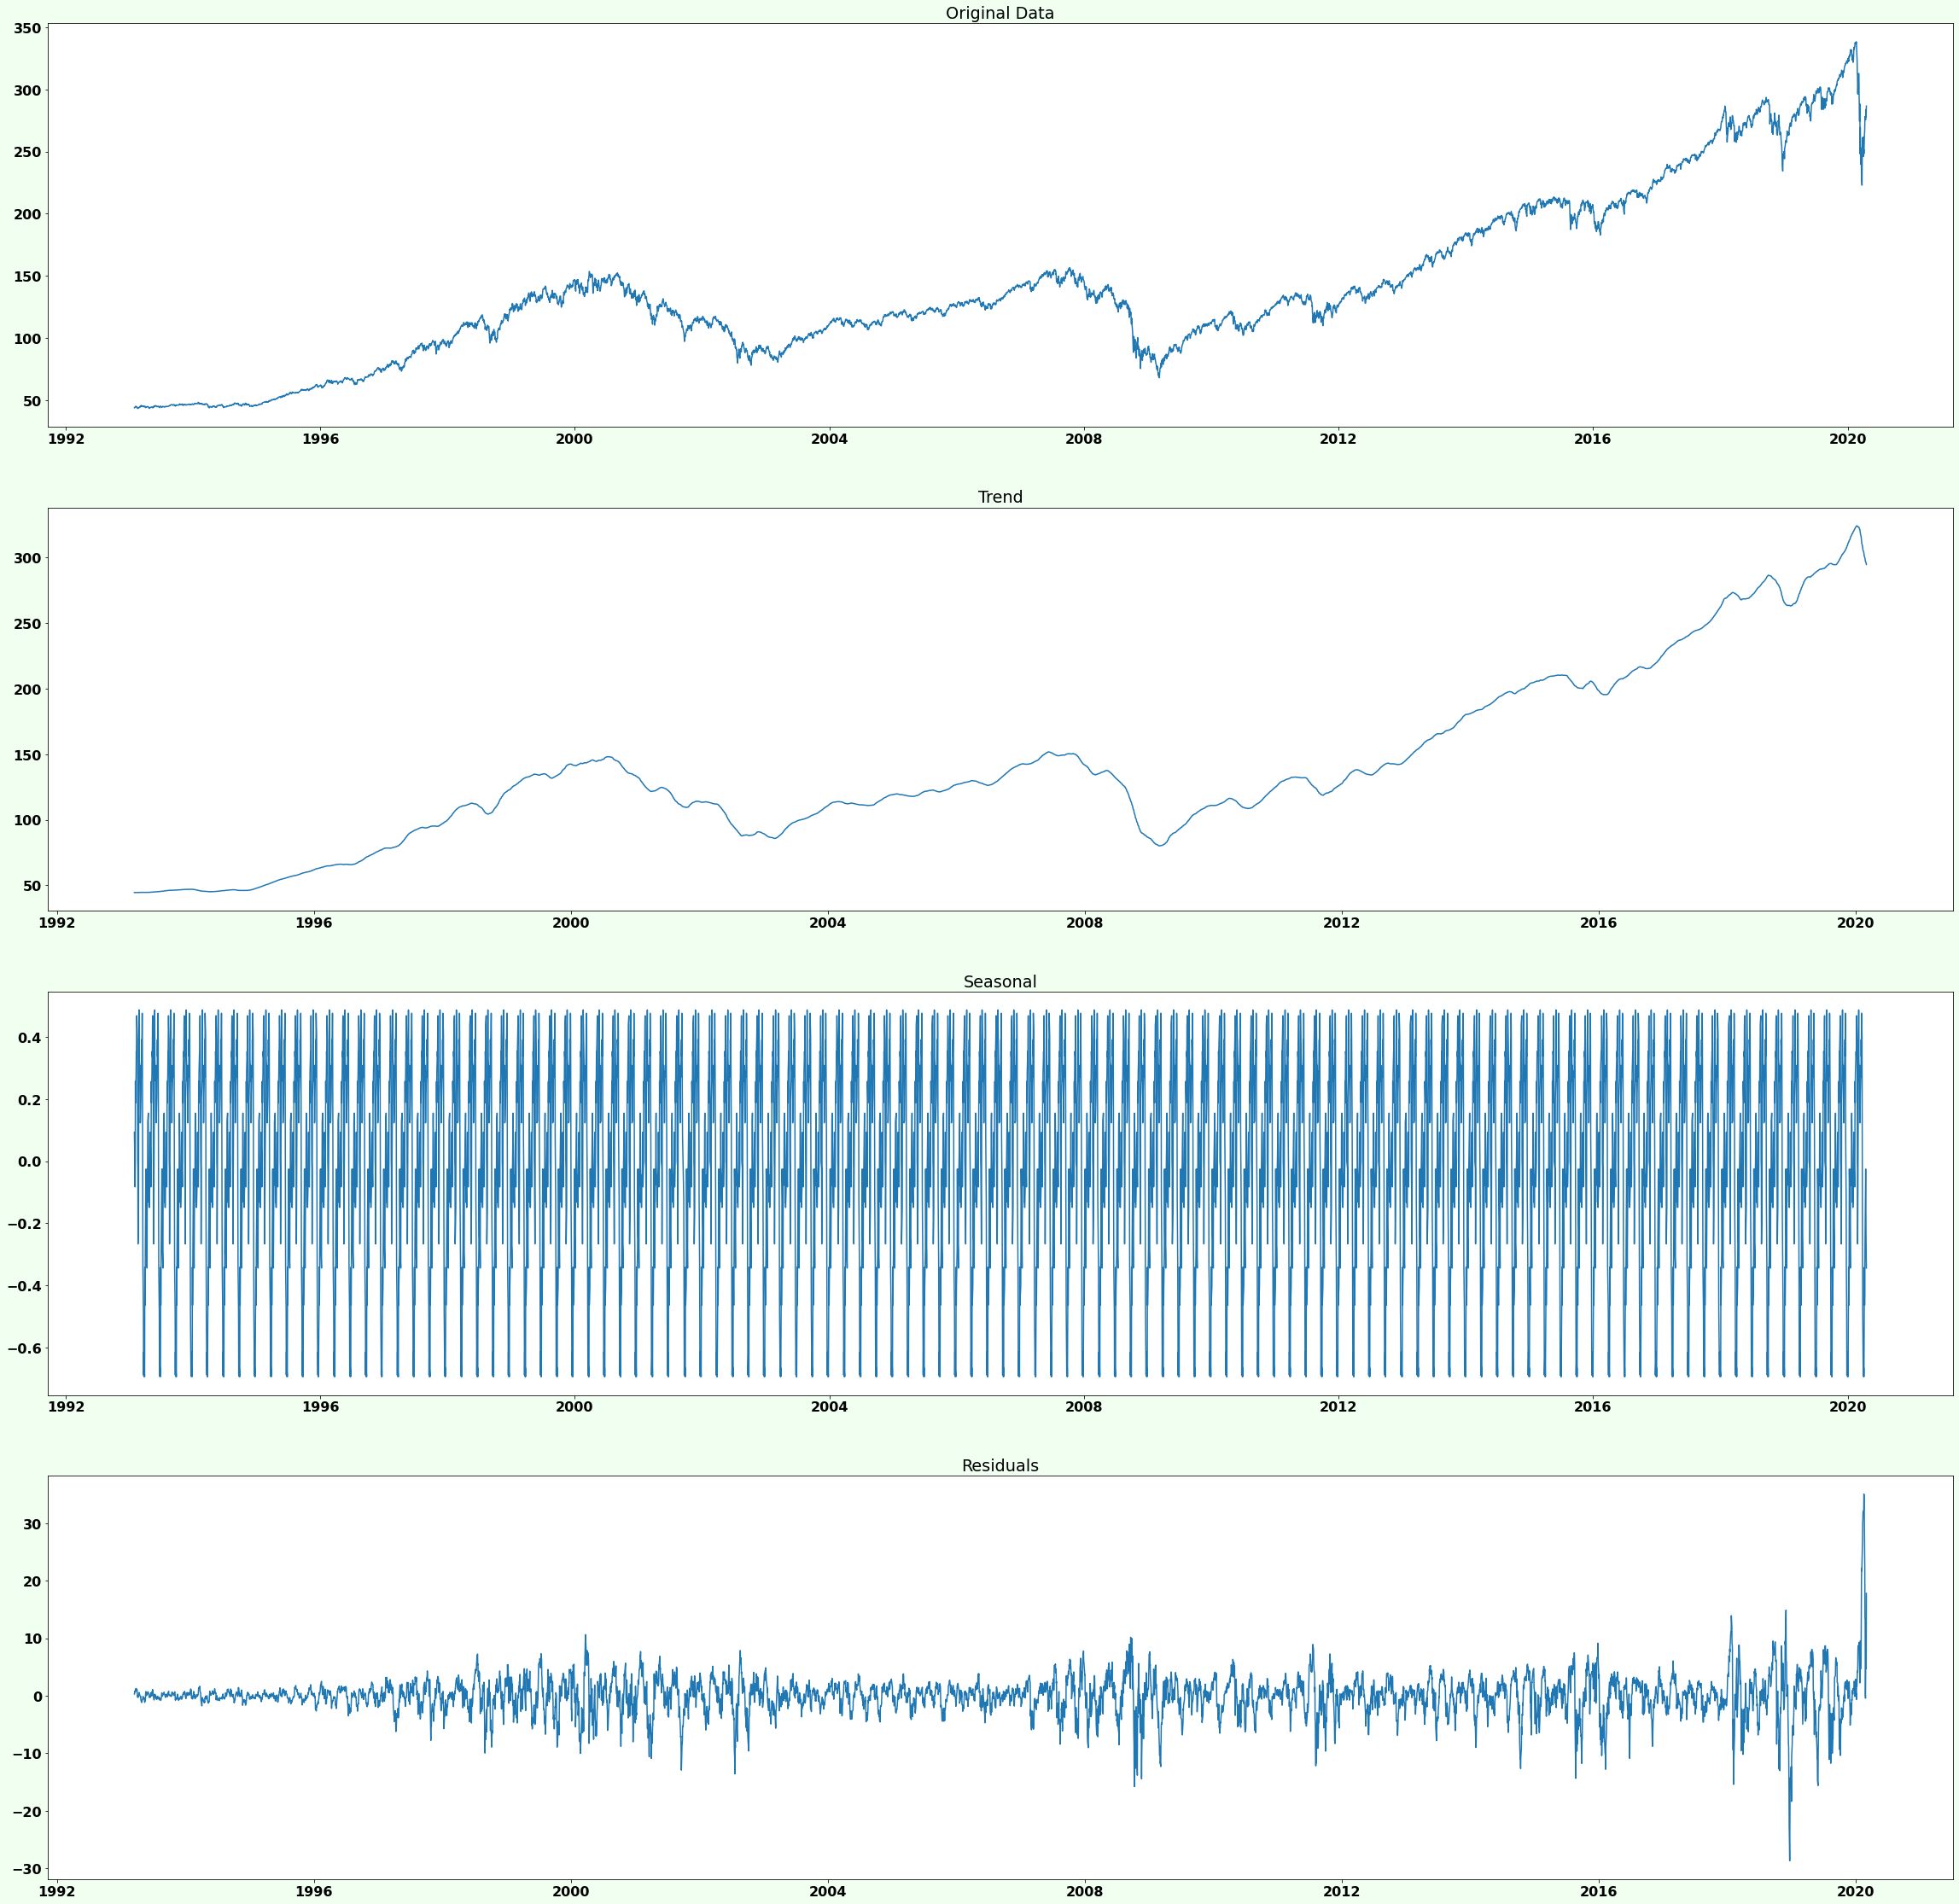

In [12]:
fig = plt.figure(figsize=(40,40), facecolor = 'honeydew')
ax = fig.add_subplot(4,1,1)
ax.plot(data, label = 'original')
ax.set_title('Original Data')
ax = fig.add_subplot(4,1,2)
ax.plot(decomp_trend, label = 'Trend')
ax.set_title('Trend')
ax = fig.add_subplot(4,1,3)
ax.plot(decomp_season, label = 'Season')
ax.set_title('Seasonal')
ax = fig.add_subplot(4,1,4)
ax.plot(decomp_resid, label = 'Residuals')
ax.set_title('Residuals')
fig.show()


	Dickey Fuller Test

H_O = Series is Not Stationary
H_A = Series is Stationary


Test Statistic         -1.769759e+01
p-Value                 3.548936e-30
Lags Used               2.300000e+01
Observations Used       6.768000e+03
Critical Value (1%)    -3.431317e+00
Critical Value (5%)    -2.861967e+00
Critical Value (10%)   -2.566997e+00
dtype: float64


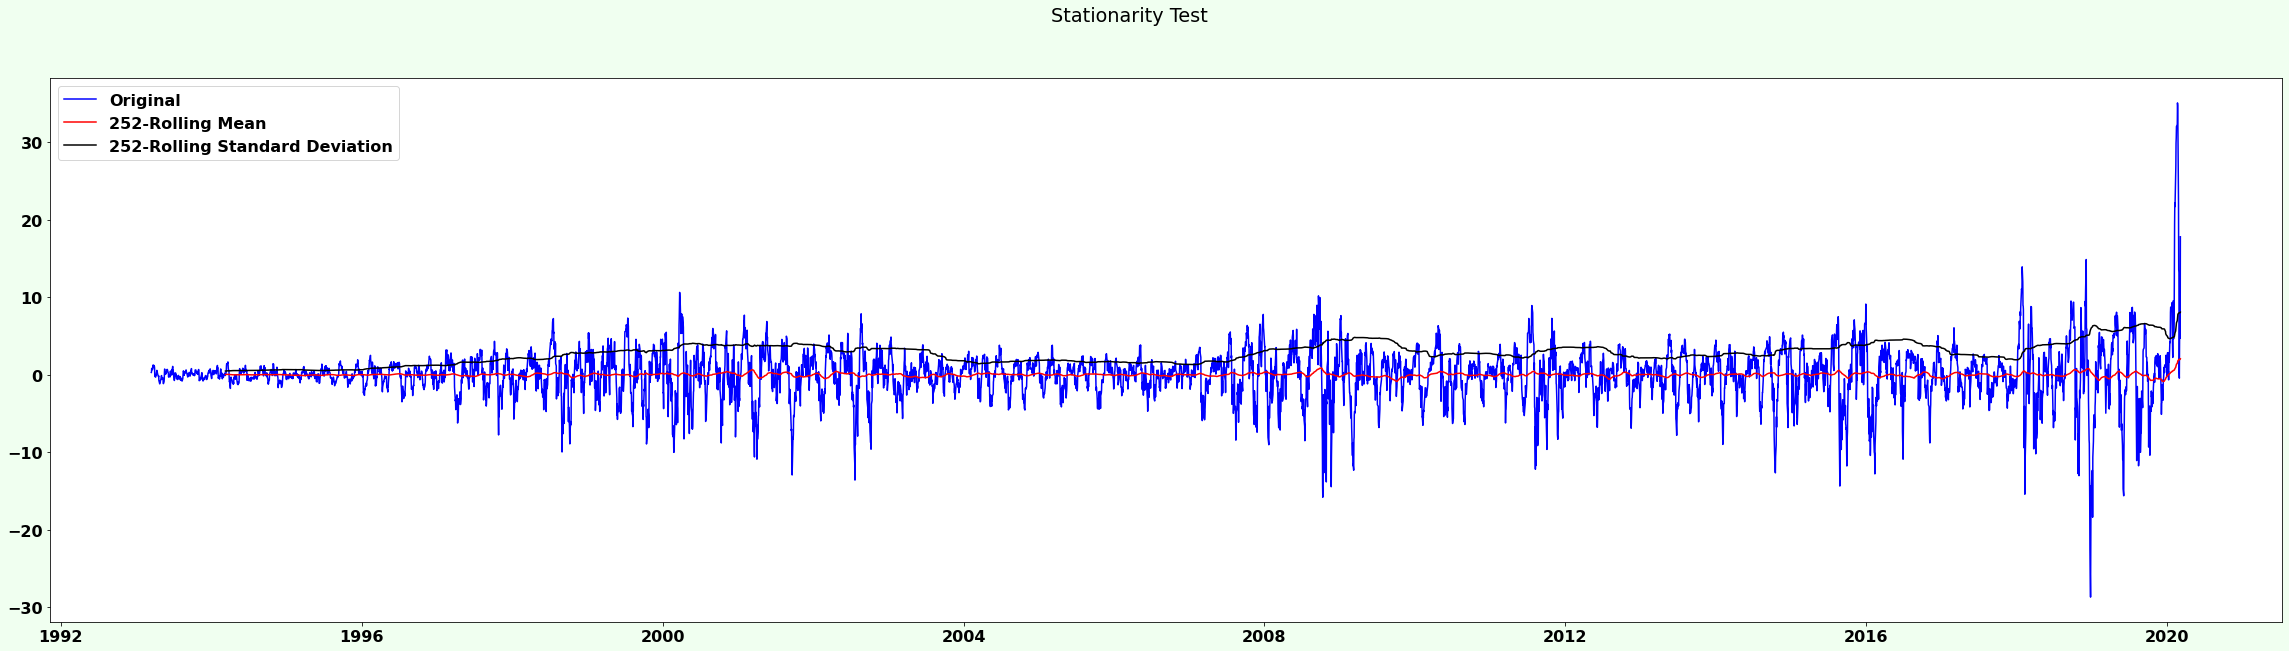

In [13]:
decomp_resid.dropna(inplace=True)
stationary_test(decomp_resid)

## **Some Observations**

We see that performing the stationarity test on the residuals leads us to conclude that the series is indeed stationary. Constant mean and variance, and it also passes the Dickey-Fuller test. *Below we perform some more transformations--**differencing** and **log-transformations**--to make our series more stationary.*

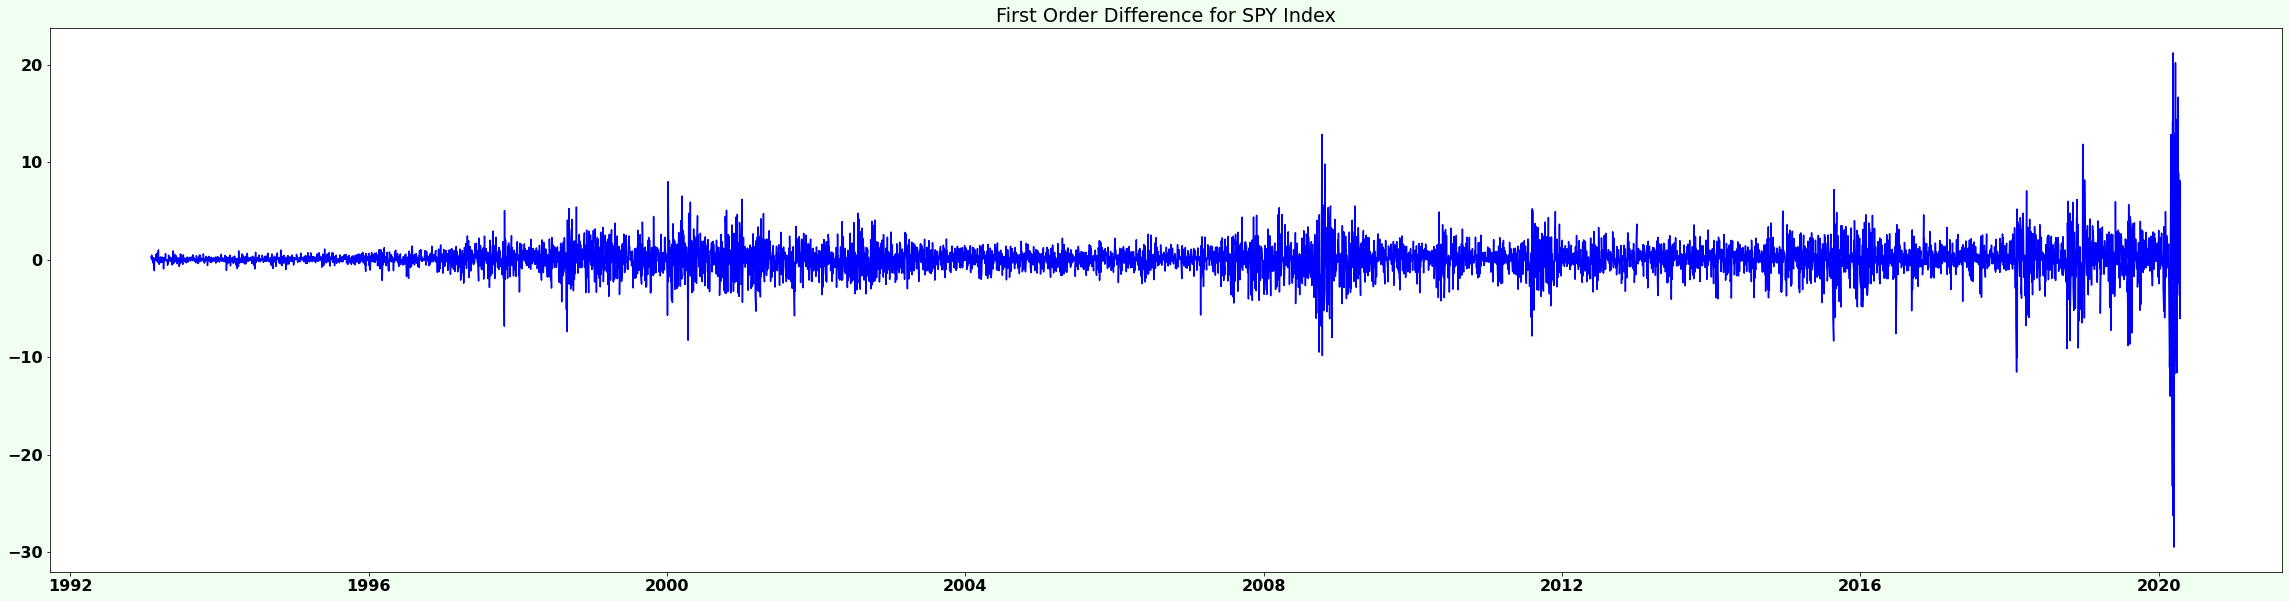

In [15]:
data_diff = data - data.shift()
plot_series(data_diff, 'First Order Difference for SPY Index')

	Dickey Fuller Test

H_O = Series is Not Stationary
H_A = Series is Stationary


Test Statistic         -1.802870e+01
p-Value                 2.680674e-30
Lags Used               2.500000e+01
Observations Used       6.827000e+03
Critical Value (1%)    -3.431308e+00
Critical Value (5%)    -2.861963e+00
Critical Value (10%)   -2.566995e+00
dtype: float64


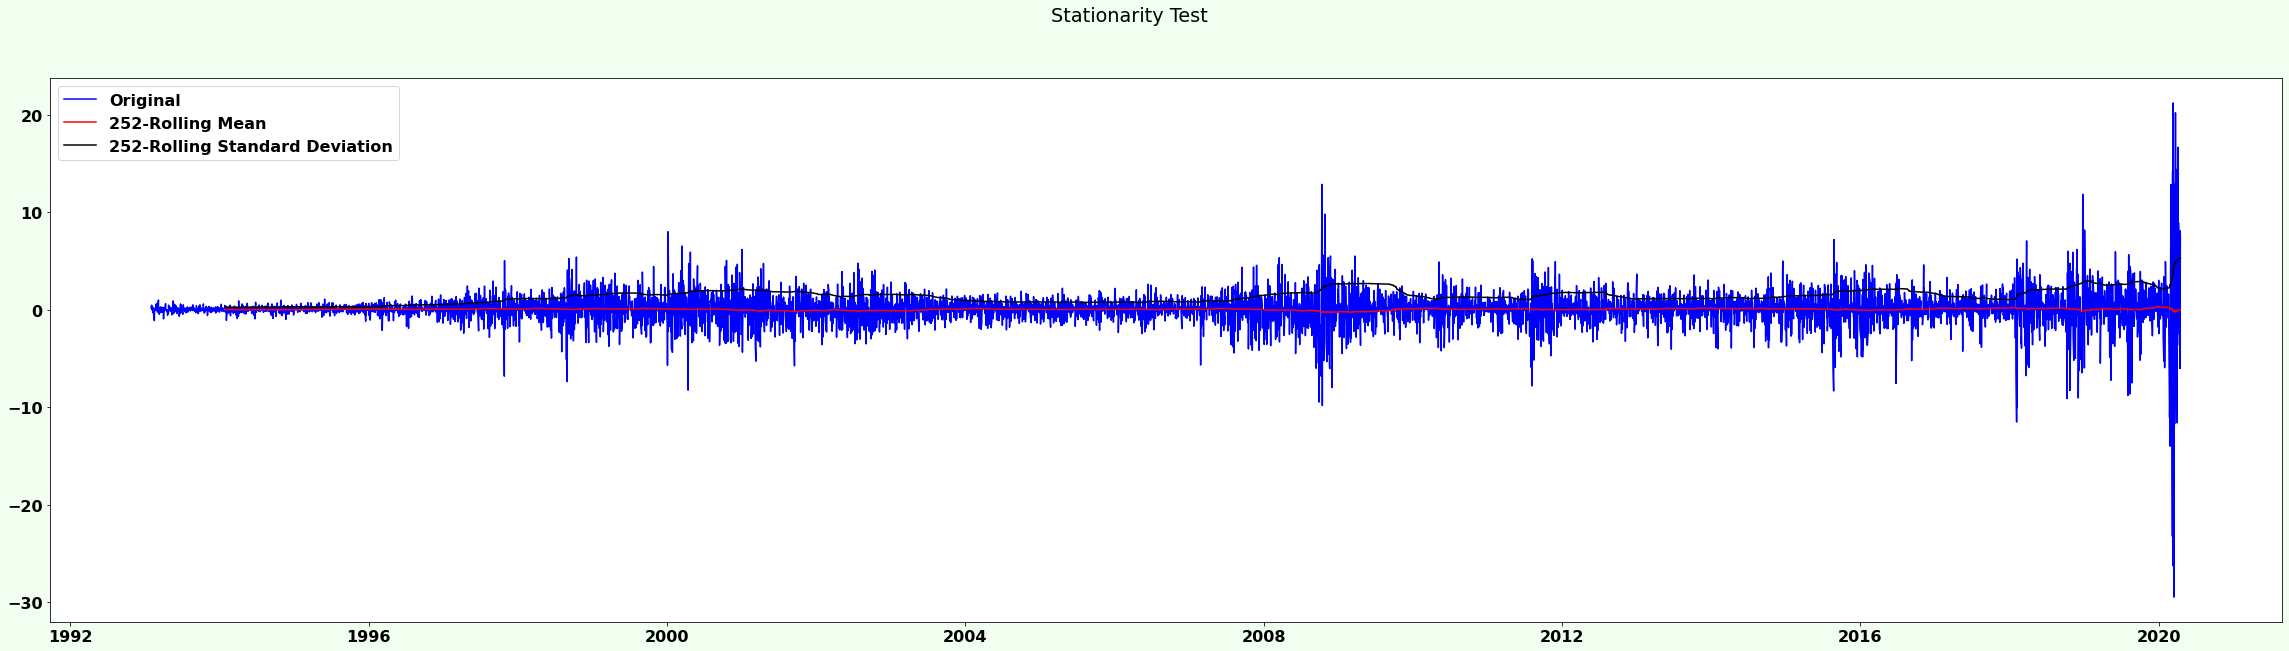

In [16]:
data_diff.dropna(inplace=True)
stationary_test(data_diff)

	Dickey Fuller Test

H_O = Series is Not Stationary
H_A = Series is Stationary


Test Statistic         -1.527095e+01
p-Value                 4.717896e-28
Lags Used               3.300000e+01
Observations Used       6.819000e+03
Critical Value (1%)    -3.431309e+00
Critical Value (5%)    -2.861964e+00
Critical Value (10%)   -2.566996e+00
dtype: float64


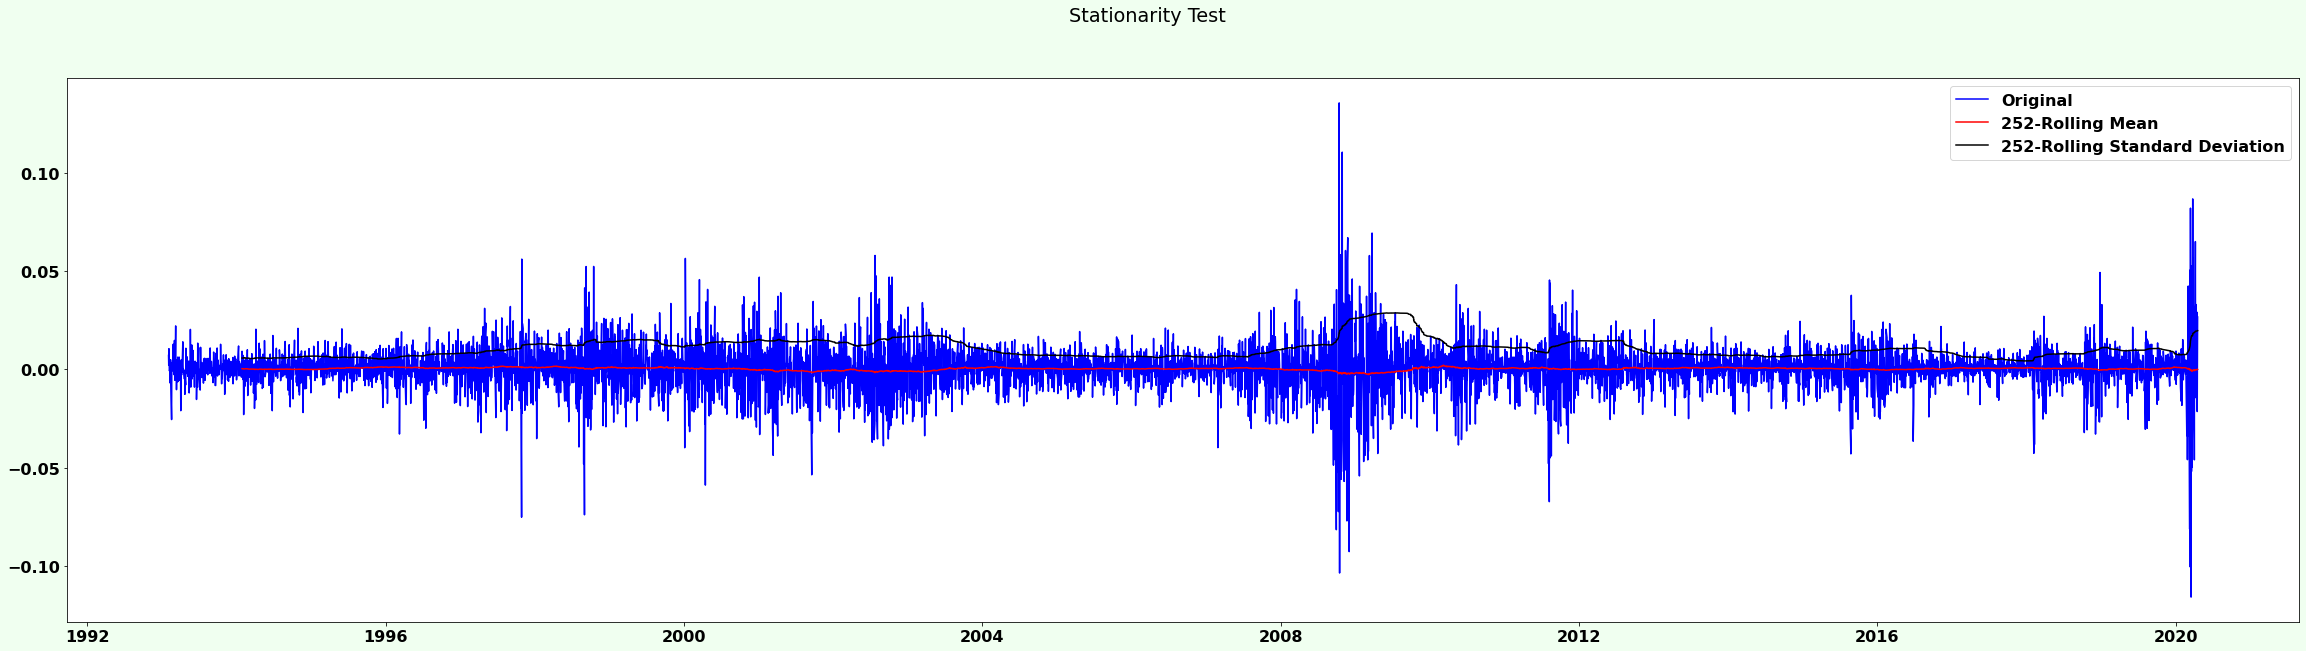

In [17]:
data_log = np.log(data)
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace = True)
stationary_test(data_log_diff)

# **ACF and PACF Plots**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Auto-Correlation Function Plots')

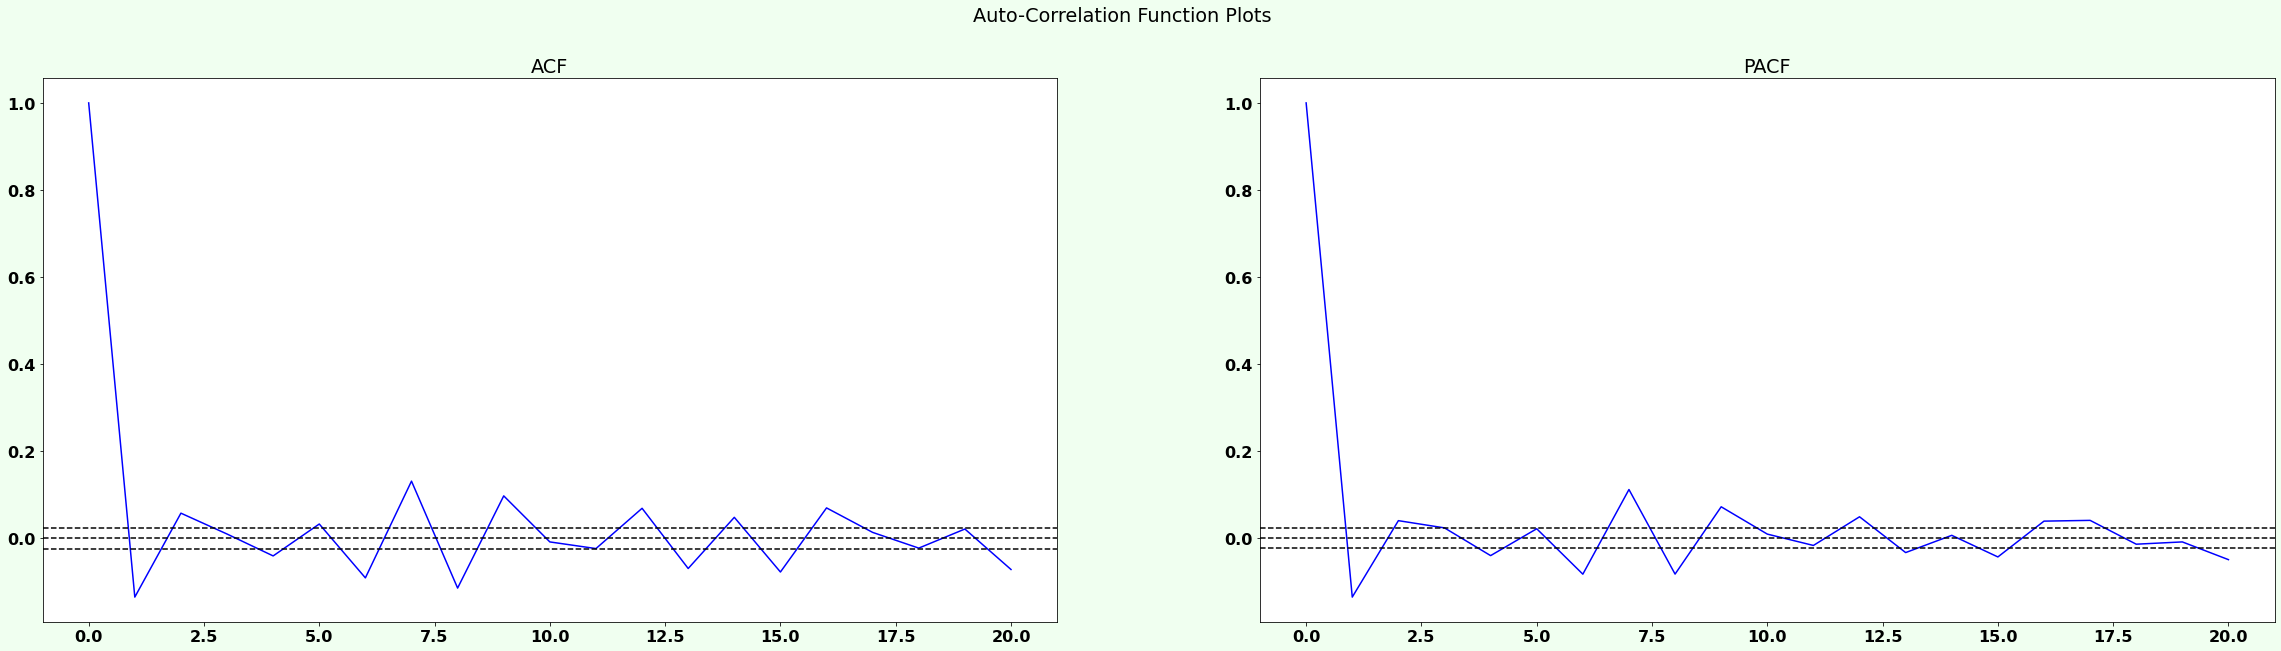

In [18]:
data_diff.dropna(inplace = True)
data_acf = acf(data_diff, nlags = 20)
data_pacf = pacf(data_diff, nlags = 20, method = 'ols')
up_cl = 1.96/np.sqrt(len(data_diff))
down_cl = (-1)*up_cl
fig = plt.figure(figsize=(40,10), facecolor = 'honeydew')

ax = fig.add_subplot(1,2,1)
ax.plot(data_acf, color = 'blue', label = 'ACF')
ax.axhline(y = 0, linestyle = '--', color = 'black')
ax.axhline(y = up_cl, linestyle = '--', color = 'black')
ax.axhline(y = down_cl, linestyle = '--', color = 'black')
ax.set_title('ACF')

ax = fig.add_subplot(1,2,2)
ax.plot(data_pacf, color = 'blue', label = 'PACF')
ax.axhline(y = 0, linestyle = '--', color = 'black')
ax.axhline(y = up_cl, linestyle = '--', color = 'black')
ax.axhline(y = down_cl, linestyle = '--', color = 'black')
ax.set_title('PACF')
fig.suptitle('Auto-Correlation Function Plots')

# **ARIMA Model & Forecast**

In [19]:
arima_model = ARIMA(data_log_diff, order = (1,0,0))
arima_results = arima_model.fit(disp = -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


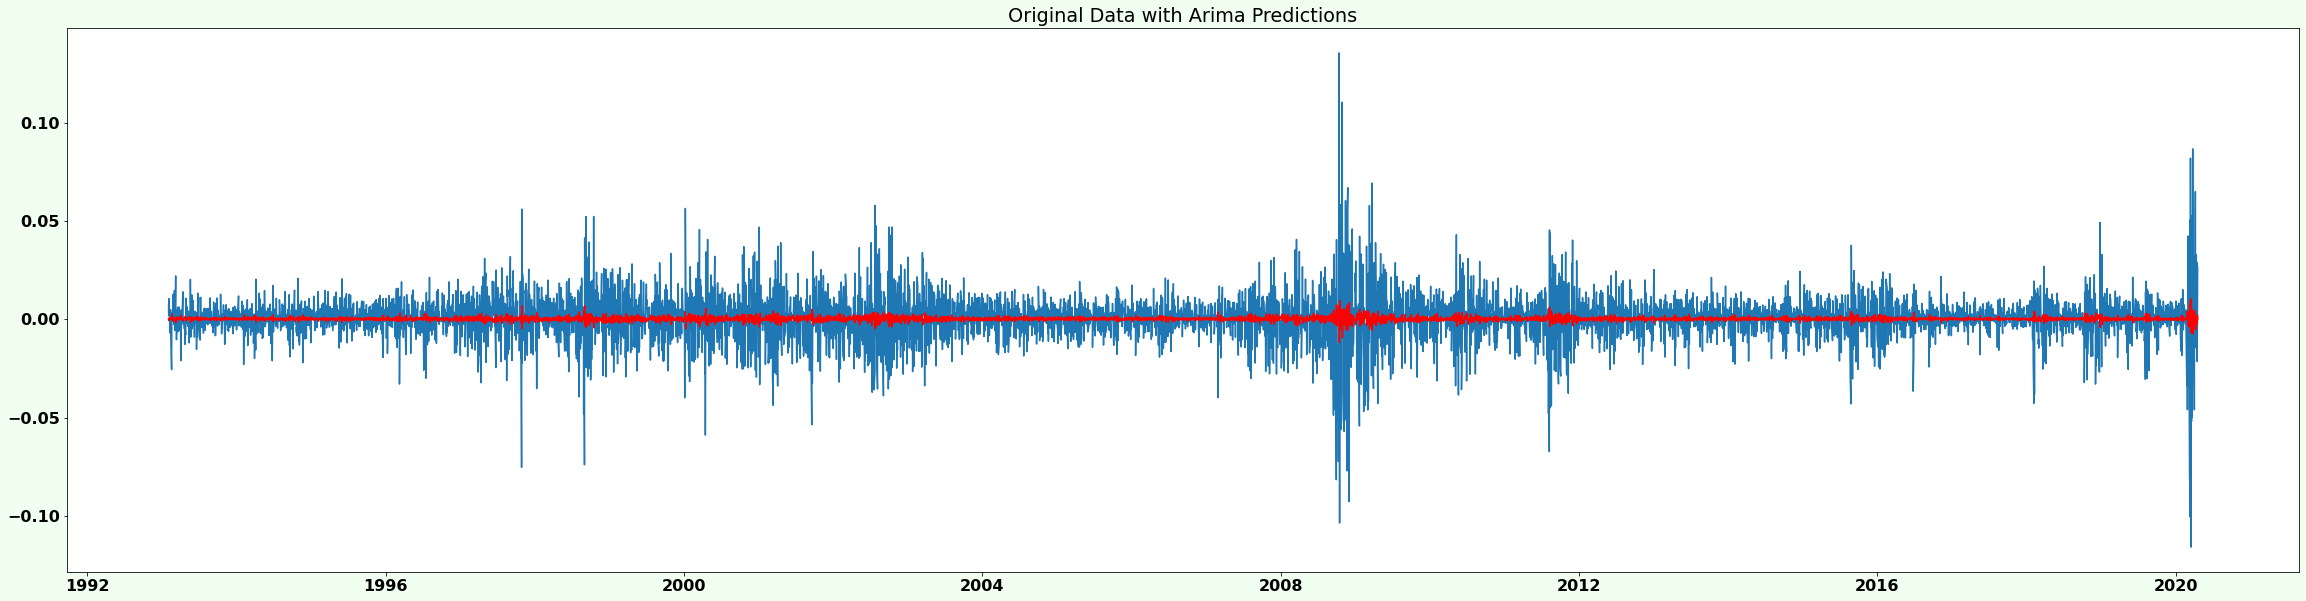

In [20]:
fig = plt.figure(figsize=(40,10), facecolor = 'honeydew')
plt.plot(data_log_diff)
plt.plot(arima_results.fittedvalues, color = 'red')
plt.title('Original Data with Arima Predictions')
plt.show()

In [21]:
data_preds = pd.Series(arima_results.fittedvalues, copy = True)
data_preds.head(10)

Date
1993-02-01    0.000273
1993-02-02   -0.000327
1993-02-03    0.000111
1993-02-04   -0.000628
1993-02-05   -0.000070
1993-02-08    0.000358
1993-02-09    0.000297
1993-02-10    0.000911
1993-02-11    0.000174
1993-02-12   -0.000132
dtype: float64

In [22]:
data_preds_cum = data_preds.cumsum()
data_preds_original = pd.Series(data_log.iloc[0], index = data.index)
data_preds_original = data_preds_original.add(data_preds_cum, fill_value = 0)
data_preds_original = np.exp(data_preds_original)
data_preds_original.head(10)

Date
1993-01-29    43.937500
1993-02-01    43.949509
1993-02-02    43.935157
1993-02-03    43.940035
1993-02-04    43.912431
1993-02-05    43.909346
1993-02-08    43.925090
1993-02-09    43.938152
1993-02-10    43.978209
1993-02-11    43.985871
dtype: float64

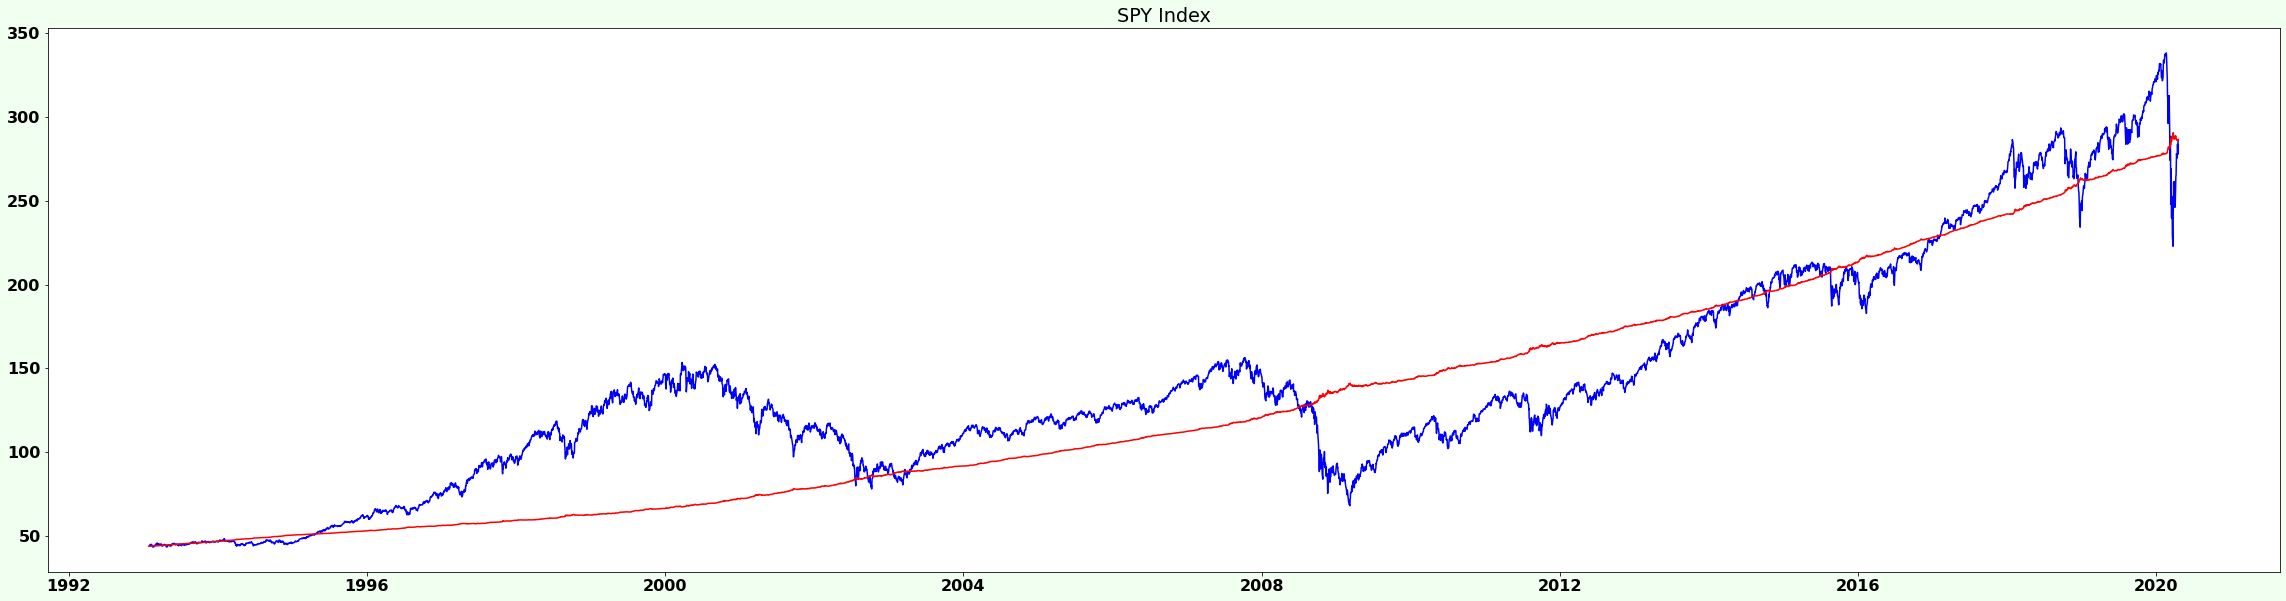

In [23]:
fig = plt.figure(figsize=(40,10), facecolor = 'honeydew')
ax = fig.add_subplot(1,1,1)
ax.plot(data, color = 'blue')
ax.plot(data_preds_original, color = 'red', label = 'Forecasted Values')
ax.set_title('SPY Index')
fig.show()

# **Conclusion**

You can probably tell by now, we have reached a similar conclusion as in the previous project. The ARIMA model for forecasting the SPY time-series isn't a potent method. If the neural network model gave approximately 50% odds of predicting the daily trends, the ARIMA models were destined to fail. Nevertheless, the underlying goal of this project was to explore the stationarity testing and building ARIMA models. 

*Despite our consecutive failures in predicting the stock market, Time Series Analysis and Forecasting are still a potent tool to have for a Data Scientist. The applications are not limited strictly to the world of stocks and ETFs, and in different settings the models are actually quite potent.*